In [36]:
# Adaline filter to Denoise a Soundtrack

In this model, we try to reproduce a sound signal, s, which is contaminated by some noise, v, from a specific noise source. A sinusoidal noise of a given frequency is generated and passed through a noise filter which would finally be added to the original signal generating a noisy contaminated signal, t. This sinusoidal wave is fed to the adaptive filter, with an attempt to regenerate the part of t that is linearly correlated with v, that is m. In this way, the error e, will be close to the original uncontaminated signal, s.

# Importing Libraries
- Numpy - for Mathematical Calculation
- Matplotlib - used for Plotting of Graphs
- Sk_dsp_comm - for signal processing 

In [11]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import sk_dsp_comm.sigsys as ss

In [12]:
#from_wav() converts the wav format to a digital value
fs,src = ss.from_wav('OSR_us_000_0030_8k.wav')
#To set the frequency of the wave
frequency = 100
fs = 8000/frequency
#Setting the volume of the track
volume = 0.98  
#Duration of the track
duration = 6   
f = 1       
#Samples is the sinosuidal wave of frequency x and volume y generated for simulating the noise
samples = (volume*np.sin(2*np.pi*np.arange(fs*duration*(8000/fs))*f/fs)).astype(np.float32)
end = 15000+8000*duration
#r_in_org contains the track segment to which we wish to add the noise
r_in_org=src[16000:end]
#r_in contains the original track with the noise segment
r_in=src[16000:end]+samples


ValueError: operands could not be broadcast together with shapes (31000,2) (48000,) 

In [15]:
#r is the no of the time steps/samples we wish to look back  to feed to our adaline network. 
#That is, r denotes the number of outputs in our tapped delay line
r = 16
s = r_in_org
v = samples
#m is the simulation of the wave passing through the noise filter
m = 0.9*(volume*np.sin(np.pi/2 + 2*np.pi*np.arange(fs*duration*(8000/fs))*f/fs)).astype(np.float32)
#t contains the original track with the wave from noise filter (m)
t = m+s
plt.plot(t)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title(' Signal with noise')
#saving t to wav format for playback
ss.to_wav('OSR_us_30_8k_in.wav', 8000, t)
import IPython
#Playing t
IPython.display.Audio('OSR_us_30_8k_in.wav')

ValueError: operands could not be broadcast together with shapes (48000,) (31000,2) 

In [16]:
"""
Preparing the data for the network
Since the input of the adaline exist with value from previous time steps,
the values for each sample is enlisted in the given forat
"""
data  = []
for  i in range(r-1,v.shape[0]):
    lister = []
    for i in range(r-1,-1,-1):
        lister.append(v[i])
    data.append(lister)
data = np.asarray(data)
target = np.asarray(m[r-1:])

In [17]:
input_mat=data
num_features=data.shape[1]
training_size=data.shape[0]

#The ADALINE weight update rule
def weight_update(weight_vec,err_val,input_vec,lr):
    wlen=len(weight_vec)-1
    change=2.0*lr*err_val
    for i in range(wlen):
        weight_vec[i]+=change*input_vec[i]
    #The weight update rule for the bias
    weight_vec[-1]+=change
    return weight_vec

In [18]:
length=r
data = np.array(data)
data = data.reshape(-1, 1)
patterns=data.shape[1]
e_plot=[]
error=[]
bias=[1]

In [19]:
def main(t):
    weight_vec=np.random.random_sample(r)         #initializing a random weight vector
    choices=np.arange(0.1,0.2,0.1)               #initializing choices for tuning the learning rate
    
    #The following code tries out various learning rates to find the best one.
    for k in range(len(choices)):
        weight_vec=np.random.random_sample(r)
        weight_vec = np.append(weight_vec,bias)
        lr=choices[k]

        for i in range(target.shape[0]): 
            true=target[i]
            pred = 0
            for j in range(r):
                pred+=(input_mat[i][j]*weight_vec[j])
            pred+=weight_vec[-1]
            err_val=true-pred  #computing error of the prediction
            error.append(np.abs(err_val))
            e_plot.append(t[r-1+i]-pred)
            weight_vec=weight_update(weight_vec,err_val,input_mat[i],lr)  #updating the weight vector suitably
         
    return weight_vec          #returns the final updated weight vector
        
weight_vec=main(t)


NameError: name 't' is not defined

In [20]:
e_plot=np.array(e_plot)

Text(0.5, 1.0, 'Comparision of Original Signal(Orange) vs Reproduced Signal(Blue)')

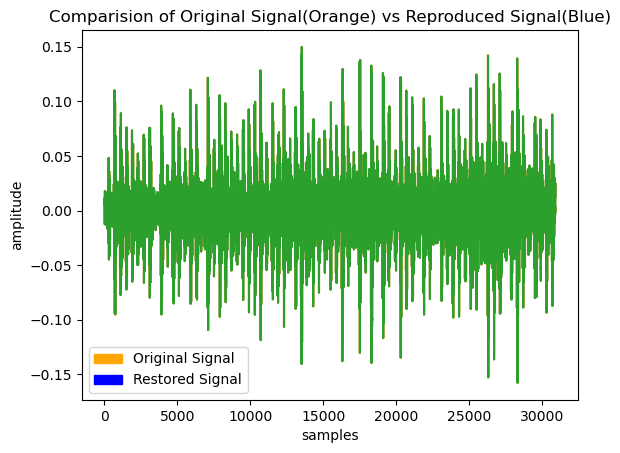

In [21]:
plt.plot(e_plot[100:])
plt.plot(s[100:])
plt.xlabel('samples')
plt.ylabel('amplitude')
orange_patch = mpatches.Patch(color='orange', label='Original Signal')
blue_patch = mpatches.Patch(color='blue', label='Restored Signal')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Comparision of Original Signal(Orange) vs Reproduced Signal(Blue)')

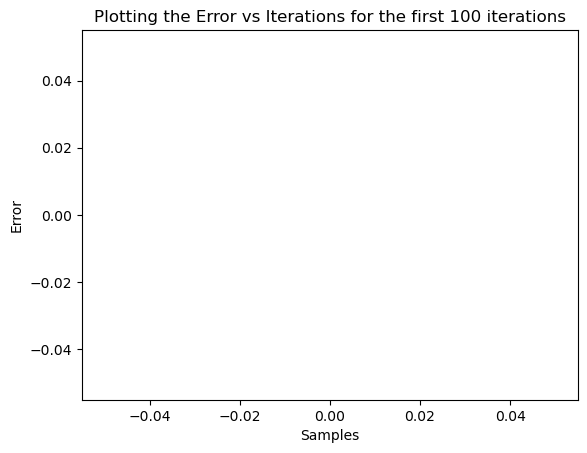

In [22]:

plt.xlabel('Samples')
plt.ylabel('Error')
plt.title('Plotting the Error vs Iterations for the first 100 iterations')
plt.plot(error[:100])

# REPRODUCED SOUND


In [23]:
ss.to_wav('OSR_us_30_8k_out.wav', 8000, e_plot.astype(np.float32))
import IPython
IPython.display.Audio('OSR_us_30_8k_out.wav')

# ORIGINAL SOUND

In [26]:
ss.to_wav('OSR_us_000_0030_8k.wav', 8000,s)
import IPython
IPython.display.Audio('OSR_us_000_0030_8k.wav')

# References
    

1. Howard B. Demuth , Mark H. Beale , Orlando De Jess , Martin T. Hagan, Neural Network Design, Martin Hagan, 2014
2. The speech .wav file was taken from an Open Speech Repository: http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0030_8k.wav